In [1]:
from pathlib import Path
from analysis_funcs import gateData, getTomos, IFs, fidelityCurve, fidelityCurve_noise, IFs_gaussianNoise, plotPTMMap, plotPTMMap_theory
%matplotlib inline

# User Parameters

Combinations for data used in the two-qubit paper are:

gateName = 'CNOT', rabiStrengthMHz = 7.5, 12
gateName = 'SWAP', rabiStrengthMHz = 7.5, 10
gateName = 'sqrtSWAP', rabiStrengthMHz = 10

In [2]:
gateName = 'SWAP'
rabiStrengthMHz = 10
gateIndices = range(20)

# Analysis

In [3]:
if gateName == 'CNOT':
    date = '2022-03-11_0'
    if rabiStrengthMHz == 7.5:
        basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points' / 'gateData_allRepeats'
    elif rabiStrengthMHz == 12:
        basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points'
elif gateName == 'SWAP':
    basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points'
    if rabiStrengthMHz == 7.5:
        date = '2022-03-12_0'
    elif rabiStrengthMHz == 10:
        date = '2022-03-26_0'
elif gateName == 'sqrtSWAP':
    basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points'
    if rabiStrengthMHz == 10:
        date = '2022-05-07_0'

In [4]:
gateDataVals = gateData(gateName, basePath, date, gateIndices)

In [5]:
tomos = getTomos(basePath, date, gateIndices, gateDataVals)

C:\Users\joela\Desktop\Mines\MinesExpAnalysis\analysis_funcs.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


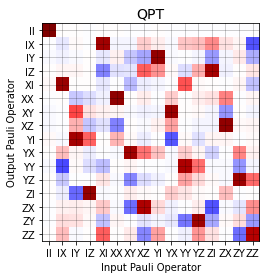

In [6]:
plotPTMMap(tomos[19])

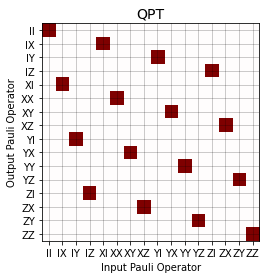

In [7]:
plotPTMMap_theory(gateDataVals)

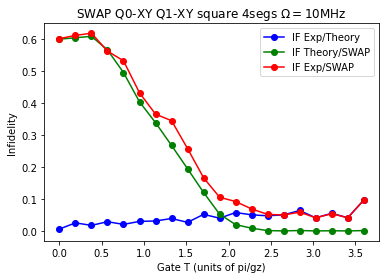

In [8]:
IFdict = IFs(basePath, date, gateIndices, gateDataVals, tomos)
fidelityCurve(gateName, rabiStrengthMHz, gateDataVals, IFdict)

In [9]:
IFdict_noise = IFs_gaussianNoise(basePath, date, gateIndices, gateDataVals, tomos, 10)

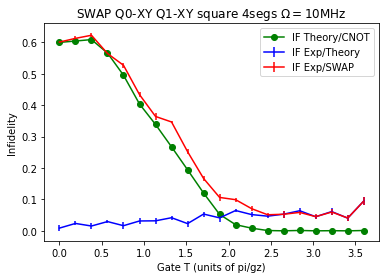

In [10]:
fidelityCurve_noise(gateName, rabiStrengthMHz, gateDataVals, IFdict, IFdict_noise)